This notebook cotains:
- [Problem Stament](#Problem-Statement)
- [Data Cleaning](#Data-Cleaning)
- [EDA](#EDA)

## Problem Statement

Two common types of questions are those related to our health and our homes. The subreddits of r/AskDocs and r/HomeImprovement ask each of these type of questions respectively. As a data scientist, I want to explore the classification of these posts and creating a model that can determine to which subreddit a post belongs. This model can have multiple use cases, such as redirecting questions from the internet to proper medical outlets. 

When evaluating the model and it's use cases, an accuracy of at least 99% to reduce the amount of misclassified questions. A focus on the cases where medical questions are not misclassified would be prefered for the severity of the cases that could be involved.

In [ ]:
#import nltk
#nltk.download('vader_lexicon')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer

import re
import glob

## Data Cleaning

First, I will concatenate the indivdual csv files that I gathered on the daily PRAW requests with the Reddit API

In [4]:
# list all csv files only
csv_files = glob.glob('../data/reddit_submissions_*.csv')
df = pd.DataFrame()
# concat the CSV files
df = pd.concat([pd.read_csv(file, index_col='Unnamed: 0') for file in csv_files ], ignore_index=True)

In [5]:
df['post_id'].nunique()

7414

In [6]:
df.shape

(35807, 6)

In [7]:
print('The number of comments with [removed]: ' , df[df['comment'] == '[removed]'].shape[0])

The number of comments with [removed]:  70


In [35]:
#Checking null values
df.isna().sum()

post_id           0
title             0
self_text         0
subreddit         0
comment           0
comment_id        0
pos_score         0
neg_score         0
neu_score         0
compound_score    0
dtype: int64

In [9]:
df.dtypes

post_id       object
title         object
self_text     object
subreddit     object
comment       object
comment_id    object
dtype: object

In [10]:
# Removing duplicates from Title and Post ID
df = df.drop_duplicates(subset = ['title', 'post_id']).copy()
df.fillna('', inplace = True)
df.head()

,post_id,title,self_text,subreddit,comment,comment_id
0,1319b5m,25F Rash on back of knee,"25F, I've had a rash on the back of my right k...",AskDocs,,
2,1319avc,idk if me or my gf have hpv or smthing why is ...,im a 20 year old girl (with a peepee) and i ha...,AskDocs,,
3,13199bu,bruise after blood test?,20f uk \n\njust concerned cause it’s been over...,AskDocs,,
4,13199a7,Heart palpitations while pushing during a bowe...,Hi i (19m 186cm 89kg) have been having bad day...,AskDocs,,
5,13197g1,Left side of my body between rib cage and hip ...,"So as the title says, I [22M] have been feelin...",AskDocs,,


In [11]:
df.to_csv('../data/full_reddit_cleaned.csv', index=False)

## EDA

In [12]:
# Simple ratio of subreddits 
df['subreddit'].value_counts(normalize=True)

AskDocs            0.609927
HomeImprovement    0.390073
Name: subreddit, dtype: float64

### Text Statistics

In [13]:
def test_analysis(data, feature):
    """
    Create word count and length features based on one textual features in the dataset
    """
    data = data.drop_duplicates(subset=feature, ignore_index=True).dropna(subset=feature).copy()
    data.loc[:,'length'] = data[feature].apply(len)
    data.loc[:,'word_count'] = data[feature].apply(lambda x: len(x.split()))
    return data

#### Title Statistics

In [14]:
title_df = test_analysis(df, 'title')
title_df.head()

,post_id,title,self_text,subreddit,comment,comment_id,length,word_count
0,1319b5m,25F Rash on back of knee,"25F, I've had a rash on the back of my right k...",AskDocs,,,24,6
1,1319avc,idk if me or my gf have hpv or smthing why is ...,im a 20 year old girl (with a peepee) and i ha...,AskDocs,,,91,21
2,13199bu,bruise after blood test?,20f uk \n\njust concerned cause it’s been over...,AskDocs,,,24,4
3,13199a7,Heart palpitations while pushing during a bowe...,Hi i (19m 186cm 89kg) have been having bad day...,AskDocs,,,56,8
4,13197g1,Left side of my body between rib cage and hip ...,"So as the title says, I [22M] have been feelin...",AskDocs,,,158,29


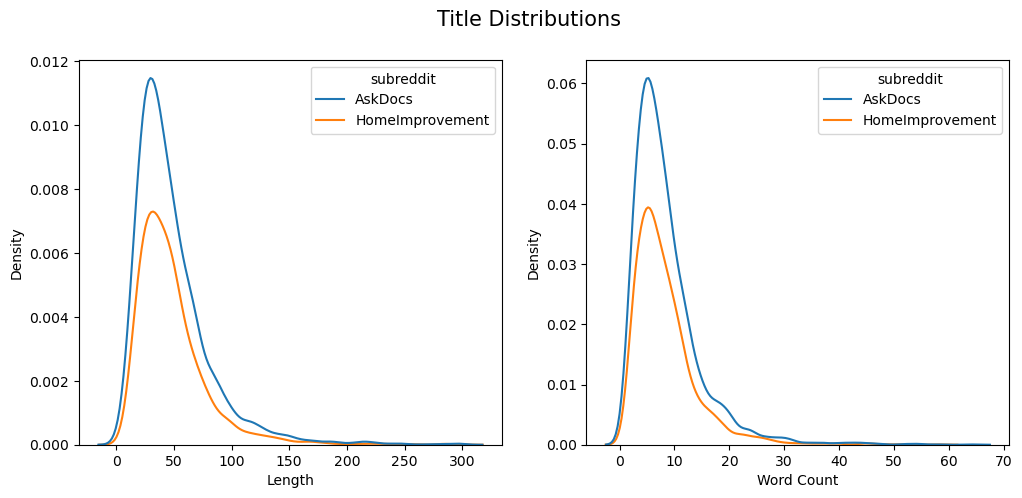

In [15]:
# Plot length and word count distributions by title
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.kdeplot(title_df, x='length', hue='subreddit',  ax=ax[0])
sns.kdeplot(title_df, x='word_count', hue='subreddit',  ax=ax[1])
ax[0].set(xlabel='Length')
ax[1].set(xlabel='Word Count')


fig.suptitle('Title Distributions', fontsize=15);

The distributions for both lenght and word count was similar to both subreddits. I will not be using this feature as created feature to help distinguish the subreddits in a classifier

#### Self-Text Statistics 

In [16]:
self_text_df = test_analysis(df, 'self_text')

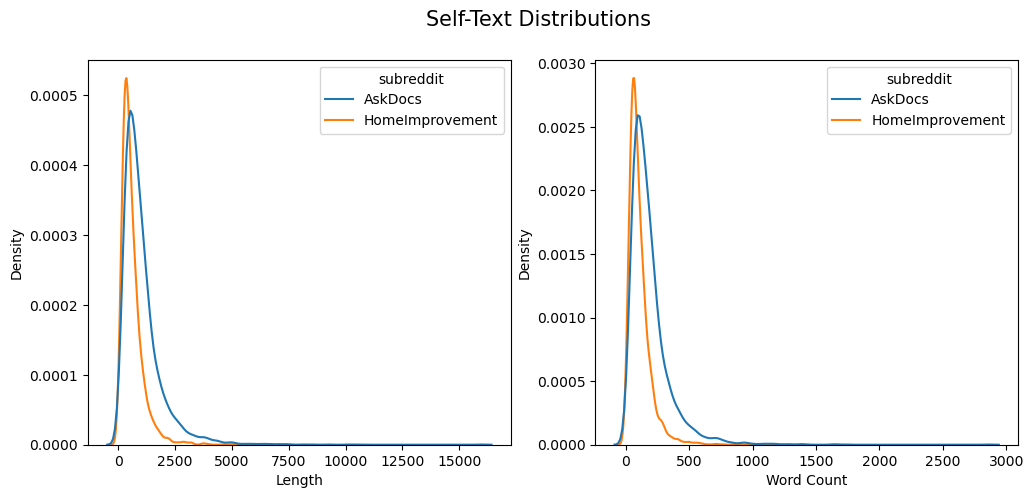

In [17]:
# Plot length and word count distributions by self text
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.kdeplot(self_text_df, x='length', hue='subreddit',  ax=ax[0])
sns.kdeplot(self_text_df, x='word_count', hue='subreddit',  ax=ax[1])
ax[0].set(xlabel='Length')
ax[1].set(xlabel='Word Count')


fig.suptitle('Self-Text Distributions', fontsize=15);

Similar to the title distributions. 

#### Comment Statistics

In [18]:
comment_df = test_analysis(df, 'comment')
comment_df[comment_df['word_count'] < 0]

,post_id,title,self_text,subreddit,comment,comment_id,length,word_count


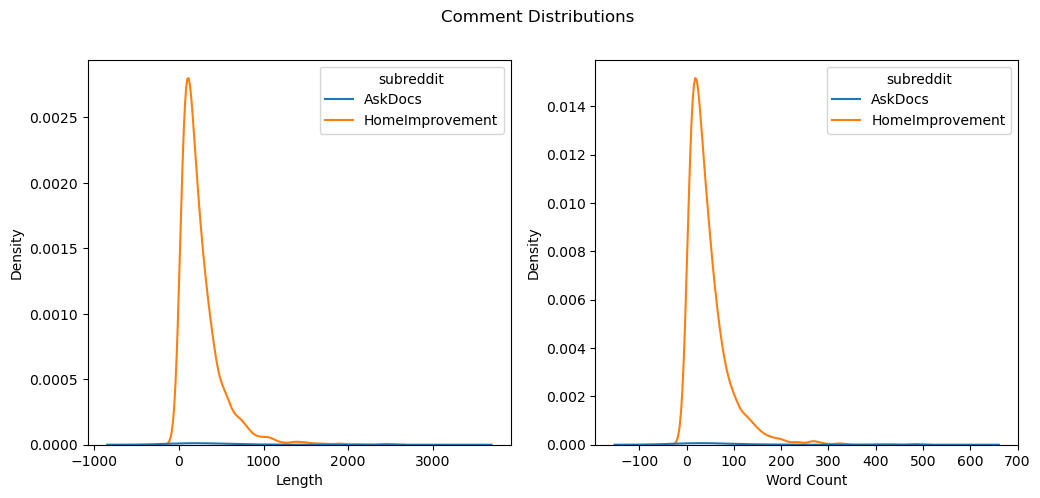

In [32]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.kdeplot(comment_df, x='length', hue='subreddit',  ax=ax[0])
sns.kdeplot(comment_df, x='word_count', hue='subreddit',  ax=ax[1])
ax[0].set(xlabel='Length')
ax[1].set(xlabel='Word Count')


fig.suptitle('Comment Distributions');
fig.savefig('../imgs/comment_distribution.png')

There are inconsistencies with the comment word count and length make it unreliable to use in further analysis. I will also not be including it in the use of any classifier models

### N-gram Comparison

In [20]:
def count_vec_feature(data, feature, gram_range:tuple):
    """
    Apply the CountVectorizer on to split dataframes by subreddit. Used to determine the the top ngrams of each subreddit
    """
    cvec = CountVectorizer(stop_words= stopwords.words('english'), ngram_range= gram_range)
    data_vect = cvec.fit_transform(data[feature])
    df = pd.DataFrame(data_vect.todense(), columns=cvec.get_feature_names_out())
    
    doc_df = data[data['subreddit'] == 'AskDocs'].copy()
    doc_vect = cvec.fit_transform(doc_df[feature])
    doc = pd.DataFrame(doc_vect.todense(), columns=cvec.get_feature_names_out())

    home_df = data[data['subreddit'] == 'HomeImprovement'].copy()
    home_vect = cvec.fit_transform(home_df[feature])
    home = pd.DataFrame(home_vect.todense(), columns=cvec.get_feature_names_out())

    return doc, home

#### Top Uni-grams

In [21]:
doc_uni_df, home_uni_df = count_vec_feature(df, 'self_text', (1,1))

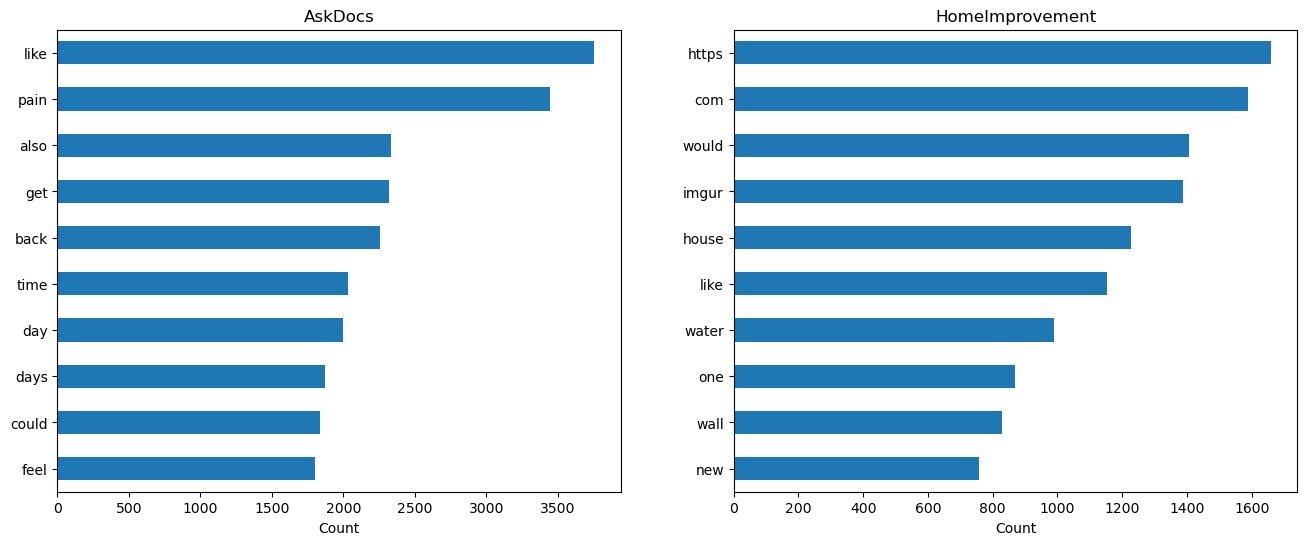

In [22]:
# Plotting top unigrams for each subreddit
fig, ax = plt.subplots(1, 2, figsize=(16,6))
doc_uni_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
home_uni_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])
ax[0].set(xlabel='Count', title='AskDocs')
ax[1].set(xlabel='Count', title='HomeImprovement')

ax[0].invert_yaxis()
ax[1].invert_yaxis();

Some of the top words in the r/HomeImprovement subreddit were based off urls, so I will have to include a check for the url count and portentially removing the urls in a preprocessor. 

#### Top Bi-grams

In [33]:
doc_bi_df, home_bi_df = count_vec_feature(df, 'self_text', (2,2))

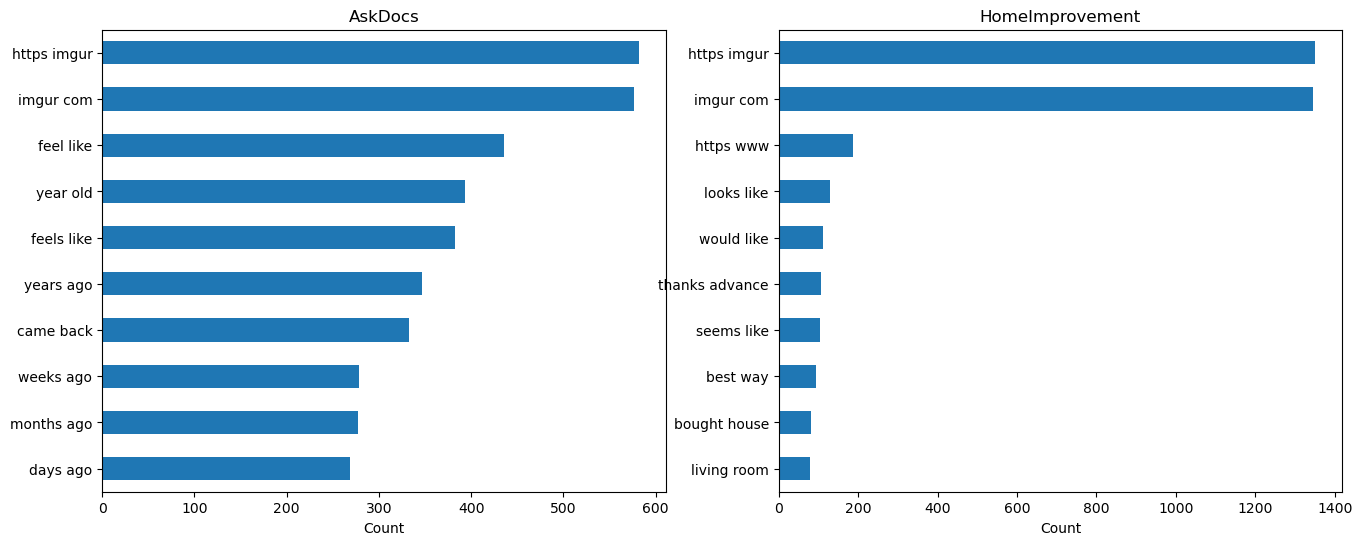

In [34]:

fig, ax = plt.subplots(1, 2, figsize=(16,6))
doc_bi_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
home_bi_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])
ax[0].set(xlabel='Count', title='AskDocs')
ax[1].set(xlabel='Count', title='HomeImprovement')
ax[0].invert_yaxis()
ax[1].invert_yaxis();

## Sentiment Analysis

In [36]:
def sentiment_scores(data, feature):
    """
    Create features for each of the text sentiment analysis scores. 
    """
    sia = SentimentIntensityAnalyzer()
    data['pos_score'] = data[feature].apply(lambda x: sia.polarity_scores(str(x))['pos']).copy()
    data['neg_score'] = data[feature].apply(lambda x: sia.polarity_scores(str(x))['neg']).copy()
    data['neu_score'] = data[feature].apply(lambda x: sia.polarity_scores(str(x))['neu']).copy()
    data['compound_score'] = data[feature].apply(lambda x: sia.polarity_scores(str(x))['compound']).copy()

    return data

In [25]:
title_sent_df = sentiment_scores(df, 'title')

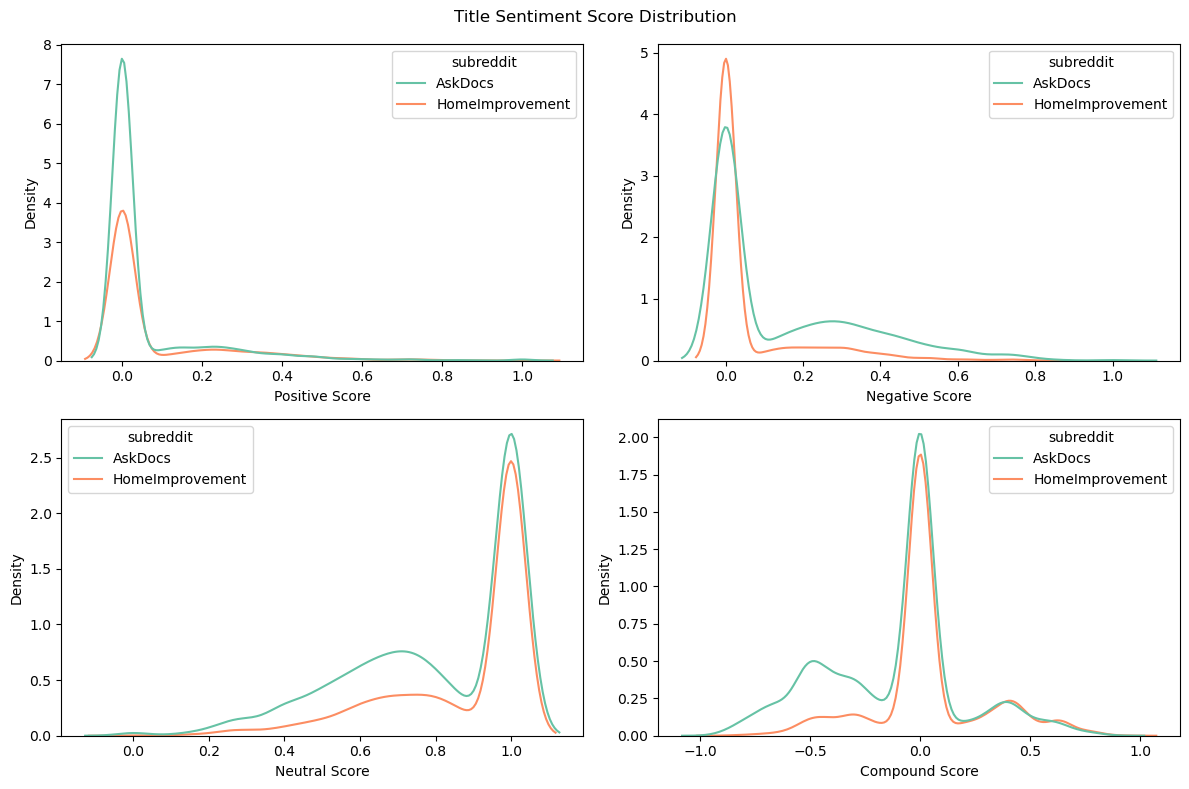

In [28]:
fig, ax = plt.subplots(2,2,figsize=(12,8))
sns.kdeplot(title_sent_df, x='pos_score', hue='subreddit', palette='Set2', ax=ax[0,0])
sns.kdeplot(title_sent_df, x='neg_score', hue='subreddit', palette='Set2', ax=ax[0,1])
sns.kdeplot(title_sent_df, x='neu_score', hue='subreddit', palette='Set2', ax=ax[1,0])
sns.kdeplot(title_sent_df, x='compound_score', hue='subreddit', palette='Set2', ax=ax[1,1])

ax[0,0].set(xlabel='Positive Score')
ax[0,1].set(xlabel='Negative Score')
ax[1,0].set(xlabel='Neutral Score')
ax[1,1].set(xlabel='Compound Score')

fig.suptitle('Title Sentiment Score Distribution');
fig.tight_layout()
fig.savefig('../imgs/sentiment_title_scores.png');

All of the score distributions are quite similar to each other and would not be suitable to use as an extra feature for the classifier models

In [29]:
text_sent_df = sentiment_scores(df, 'self_text')

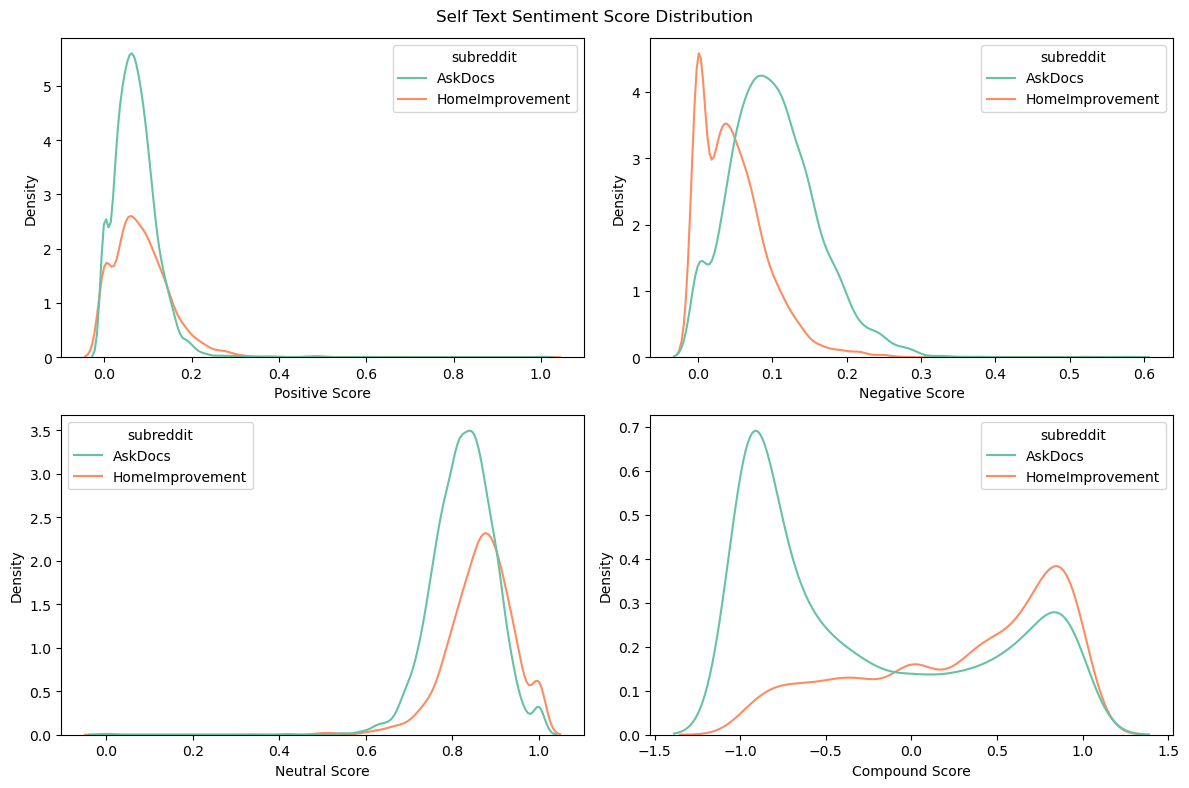

In [30]:
fig, ax = plt.subplots(2,2,figsize=(12,8))
sns.kdeplot(text_sent_df, x='pos_score', hue='subreddit', palette='Set2', ax=ax[0,0])
sns.kdeplot(text_sent_df, x='neg_score', hue='subreddit', palette='Set2', ax=ax[0,1])
sns.kdeplot(text_sent_df, x='neu_score', hue='subreddit', palette='Set2', ax=ax[1,0])
sns.kdeplot(text_sent_df, x='compound_score', hue='subreddit', palette='Set2', ax=ax[1,1])

ax[0,0].set(xlabel='Positive Score')
ax[0,1].set(xlabel='Negative Score')
ax[1,0].set(xlabel='Neutral Score')
ax[1,1].set(xlabel='Compound Score')

fig.suptitle('Self Text Sentiment Score Distribution');
fig.tight_layout()
fig.savefig('../imgs/sentiment_self_text_scores.png');

While there are subtle differences for the first 3 scores, we can we there is a distinct difference in the compund score for `self_text`. This will be a good feature to include for predictions, so I will include into the dataframe

In [91]:
#Save the cleaned dataframe with senetiment values for the self text
text_sent_df.to_csv('../data/full_subreddits_w_sentiment.csv', index=False)